# Write-Up

1. Describe the problem (4 points) :
    1. Describe the dataset
        - This dataset comes from the 2016 US Census. I've taken a subset of a dataset concerning "Means of Transportation" in order to simplify my analysis, and am using data on "income related to national poverty level" and "method of transportation".
        
    2. What the features represent
        - Each row is a zip code, and it contains the number of people for that zip code that fit into each of the gien categories.
        - Each column is a category that people can fit into. There are 6 main categories: driving alone, carpooling, public transportation, walking, unvconventional means, and working from home. These are then split into three lower levels: less than 100% of the poverty level, 100-149% of the poverty level and at least 150% of the poverty level.
        
    3. What the target variable is (trying to predict)
        - Through this analysis, I'm hoping that I will be able to predict the percentage of a zip code that lives below the poverty line based on the popularity of different modes of transportation.
        
2. Split into train and test sets (2 point)
    - 70% for training, 30% for testing

3. Implement KNN from scratch (8 points)
    1. Include plots showing quality metrics for varying numbers of k
        - Included below
    2. Recommend a value for k
        - My recomended value is $k=7$
    3. Why did you choose this value?
        - because that is the value where the KNN is most accurate

4. Train a model using Scikit learn KNN (6 points)
    1. Compare the results to part 1
    2. Include plots showing quality metrics for varying numbers of k
    3. Recommend a value for k

4. Why did you choose this value?

5. Extra credit
    1. Perform cross-validation (1 point)
    2. Visualize decision boundary in two dimensions (if your data is more than 2d only use 2 features) (1 point)
    3. 5-minute presentation of your findings (5 points)

In [159]:
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import math
import operator
import sys
from sklearn.neighbors import KNeighborsClassifier

In [135]:
# General overview of the data
names = ["numTotal", "bottomTotal", "midTotal", "topTotal", "numCTVAlone", "bottomCTVAlone", "midCTVAlone", 
         "topCTVAlone", "numCTVPool", "bottomCTVPool", "midCTVPool", "topCTVPool", "numPublic", "bottomPublic", 
         "midPublic", "topPublic", "numWalked", "bottomWalked", "midWalked", "topWalked", "numTMBO", 
         "bottomTMBO", "midTMBO", "topTMBO", "numHome", "bottomHome", "midHome", "topHome", "pUnderP"]
data = pd.read_csv("Working_Data_Raw_Training.csv", names=names)
testingData = pd.read_csv("Working_Data_Raw_Testing.csv", names=names)

In [136]:
# Normalize it to the number of people who are being asked
data_perc = data[["numCTVAlone", "numCTVPool", "numPublic", "numWalked", "numTMBO", "numHome"]].div(data["numTotal"].iloc[0], axis='columns')
data_perc["pUnderP"] = data["pUnderP"]

data_perc_testing = testingData[["numCTVAlone", "numCTVPool", "numPublic", "numWalked", "numTMBO", "numHome"]].div(data["numTotal"].iloc[0], axis='columns')
data_perc_testing["pUnderP"] = testingData["pUnderP"]


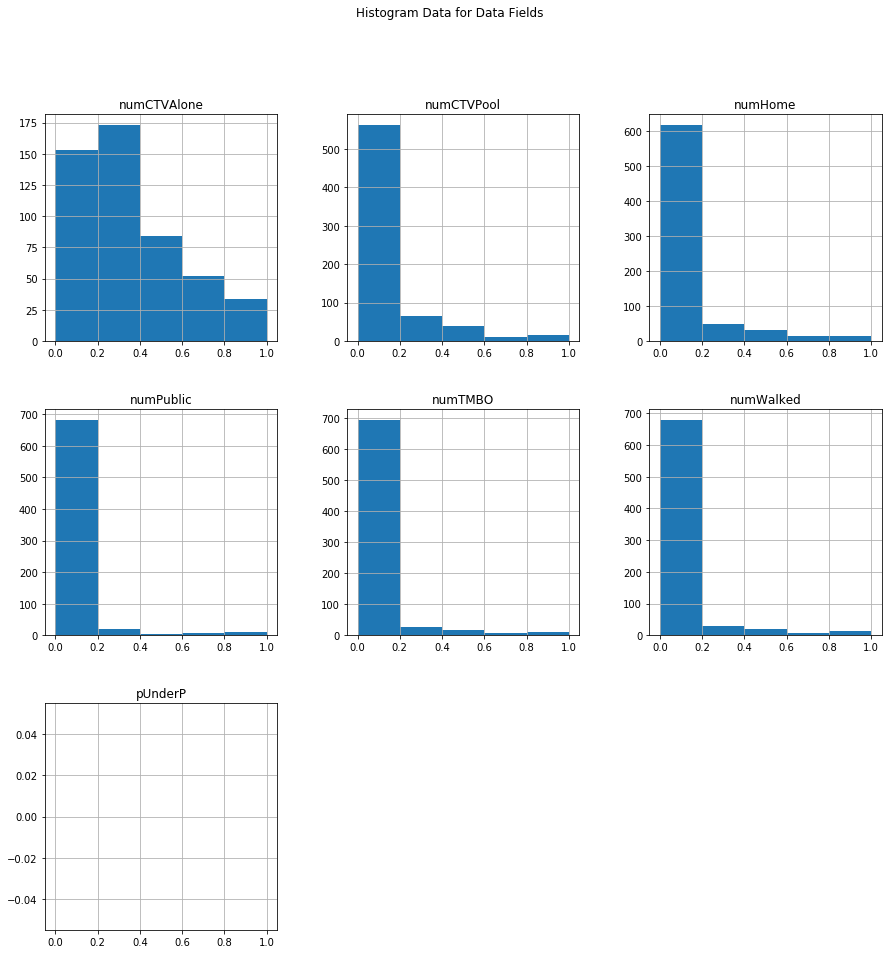

In [137]:
data_perc.hist(figsize=[15, 15], bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle('Histogram Data for Data Fields')
plt.show()

In [138]:
def euclideanDistance(row1, row2):
    distance = 0
    for x in range(len(row1)-1):
        distance += ((row1[x] - row2[x]) ** 2)
    return math.sqrt(distance)

In [139]:
distance = euclideanDistance(data_perc.iloc[0,:-2], data_perc.iloc[1,:-2])
print("Distance: " + str(distance))

Distance: 0.44946623831274074


In [140]:
def getNeighbors(source, test, k):
    smallerSource = source.loc[:, 'numCTVAlone':'numHome']
    smallerTest = test.loc['numCTVAlone':'numHome']
    # Array of distances
    distances = []
    # cycle through all for the rows in the source
    for x in range(len(source.index)):
        # compute the distance to that element
        dist = euclideanDistance(test, source.loc[x,'numCTVAlone':'numHome'])
        distances.append((source.iloc[x,:], dist))
    # sort the distances to get the closest ones
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    # Select the closest neighbors
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


In [141]:
testingSource = data_perc
testingItem = data_perc.loc[0]

In [142]:
neighbors = getNeighbors(data_perc, data_perc.loc[0], 1)
print(neighbors)

[numCTVAlone     0.868776
numCTVPool      0.084365
numPublic       0.006592
numWalked       0.009590
numTMBO         0.010597
numHome         0.020081
pUnderP        12.000000
Name: 0, dtype: float64]


In [143]:
def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return float(sortedVotes[0][0])

In [144]:
neighbors = getNeighbors(testingSource, testingItem, 1)
response = getResponse(neighbors)

In [145]:
def runKNNOnSingle(source, test, k):
    neighbors = getNeighbors(source, test, k)
    return getResponse(neighbors)
        

In [146]:
KNNresult = runKNNOnSingle(data_perc, data_perc.loc[0], 1)
print(KNNresult)

12.0


In [147]:
def testData(trainingSet, testingInput, k):
    KNNresult = runKNNOnSingle(trainingSet, testingInput, k)
    if (KNNresult == testingInput.loc['pUnderP']):
        return 1;
    else:
        return 0;

# Test for all the testing data
# Check against the actual data
# Determine a good k

In [148]:
def runTest(trainingSet, testingSet, k):
    total = len(testingSet)
    correct = 0
    for i in range(len(testingSet)):
        correct += testData(trainingSet, testingSet.loc[i], k)
    
    return correct/total

In [157]:
numOfKs = 20

k_values = [None]*numOfKs

for i in range(1, numOfKs+1):
    k_values[i] = runTest(data_perc, data_perc_testing, i)
    print("Completed k=" + str(i))

Completed k=1
Completed k=2
Completed k=3
Completed k=4
Completed k=5
Completed k=6
Completed k=7
Completed k=8
Completed k=9
Completed k=10
Completed k=11
Completed k=12
Completed k=13
Completed k=14
Completed k=15
Completed k=16
Completed k=17
Completed k=18
Completed k=19


In [198]:
k_x = []
for i in range(numOfKs):
    k_x.append(i)
    
k_y = [i * 100 for i in k_values]

k_fig = plt.figure()
k_ax = plt.axes()

k_ax.plot(k_x, k_y)

plt.xlabel("Value of k")
plt.ylabel("% Accuracy")

plt.title("Percent Accuracy as a Function of K");

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [181]:
knn_model = KNeighborsClassifier(n_neighbors=1)

# Train the model using the training sets

training_data_prebuilt_values = data[["numCTVAlone", "numCTVPool", "numPublic", "numWalked", "numTMBO", "numHome"]]
training_data_prebuilt_tags = data[["pUnderP"]]

knn_model.fit(training_data_prebuilt_values, training_data_prebuilt_tags.values.ravel())

#Predict Output
trainingPredicted= knn_model.predict(training_data_prebuilt_values)

trainingCorrectlyGuessed = 0
for i in range(len(trainingPredicted)):
    if(int(training_data_prebuilt_tags.iloc[i]) == trainingPredicted[i]):
        trainingCorrectlyGuessed+=1

print("Accuracy =", (triningCorrectlyGuessed/len(trainingCorrectlyGuessed)))

# Makes sure that this works

Accuracy = 1.0


In [182]:
# Train the model using the training sets

testing_data_prebuilt_values = testingData[["numCTVAlone", "numCTVPool", "numPublic", "numWalked", "numTMBO", "numHome"]]
testing_data_prebuilt_tags = testingData[["pUnderP"]]

#Predict Output
testingPredicted= knn_model.predict(testing_data_prebuilt_values)

testingCorrectlyGuessed = 0
for i in range(len(testingPredicted)):
    if(int(training_data_prebuilt_tags.iloc[i]) == testingPredicted[i]):
        testingCorrectlyGuessed+=1

print("Accuracy =", (testingCorrectlyGuessed/len(testingPredicted)))

# This is fucking stupid

Accuracy = 0.0967741935483871


In [191]:
prebuiltResults = [None]*numOfKs

for i in range(1, numOfKs+1):
    k_test_model = KNeighborsClassifier(n_neighbors=i)

    k_test_model.fit(training_data_prebuilt_values, training_data_prebuilt_tags.values.ravel())

    #Predict Output
    k_test_trainingPredicted= k_test_model.predict(testing_data_prebuilt_values)

    k_test_trainingCorrectlyGuessed = 0
    for j in range(len(k_test_trainingPredicted)):
        if(int(training_data_prebuilt_tags.iloc[j]) == k_test_trainingPredicted[j]):
            k_test_trainingCorrectlyGuessed+=1
    
    prebuiltResults[i-1] = (k_test_trainingCorrectlyGuessed/len(training_data_prebuilt_values))
    print("Completed k=" + str(i))

Completed k=1
Completed k=2
Completed k=3
Completed k=4
Completed k=5
Completed k=6
Completed k=7
Completed k=8
Completed k=9
Completed k=10
Completed k=11
Completed k=12
Completed k=13
Completed k=14
Completed k=15
Completed k=16
Completed k=17
Completed k=18
Completed k=19
Completed k=20


In [192]:
print(prebuiltResults)

[0.041719342604298354, 0.04298356510745891, 0.041719342604298354, 0.039190897597977246, 0.039190897597977246, 0.04298356510745891, 0.04677623261694058, 0.05309734513274336, 0.05436156763590392, 0.05436156763590392, 0.05562579013906448, 0.05941845764854614, 0.05941845764854614, 0.0606826801517067, 0.05436156763590392, 0.05436156763590392, 0.05941845764854614, 0.061946902654867256, 0.0632111251580278, 0.05436156763590392]


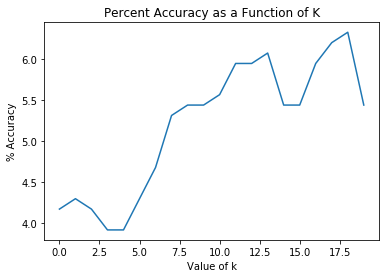

In [197]:
k_prebuilt_x = []
for i in range(numOfKs):
    k_prebuilt_x.append(i)
    
k_prebuilt_y = [i * 100 for i in prebuiltResults]

k_prebuilt_fig = plt.figure()
k_prebuilt_ax = plt.axes()

k_prebuilt_ax.plot(k_prebuilt_x, k_prebuilt_y)

plt.xlabel("Value of k")
plt.ylabel("% Accuracy")

plt.title("Percent Accuracy as a Function of K");